In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.util import img_as_float
from skimage.io import imread
from skimage.feature import peak_local_max
from scipy.signal.windows import gaussian
from scipy.fft import fft2, ifft2, fftshift, ifftshift

## 3. Scale-space feature detectors

### Problem 3.1

In [2]:
def A(image, sigma, k):
    """Computes structure tensor A"""
    x_deriv = gaussian_filter(image, sigma=sigma, order=(0,1))
    y_deriv = gaussian_filter(image, sigma=sigma, order=(1,0))

    A_matrix = np.zeros((image.shape[0], image.shape[1], 3))
    A_matrix[:,:,0] = gaussian_filter(x_deriv**2, sigma=sigma*k, order=0)
    A_matrix[:,:,1] = gaussian_filter(x_deriv*y_deriv, sigma=sigma*k, order=0)
    A_matrix[:,:,2] = gaussian_filter(y_deriv**2, sigma=sigma*k, order=0)

    return A_matrix


def R(image, sigma, k, alpha):
    """Computes scale normalized Harris corner measure"""
    A_mat = A(image=image, sigma=sigma, k=k)
    return sigma**4 * (A_mat[:,:,0]*A_mat[:,:,2] - A_mat[:,:,1]**2 - alpha * (A_mat[:,:,0] + A_mat[:,:,2])**2)


def multiscale_Harris_corner(image, k, alpha, sigma_min=0, sigma_max=5, scale_levels=50):
    sigma_values = np.logspace(sigma_min, sigma_max, scale_levels, endpoint=True, base=2)  # create scale values
    R_all_scales = np.zeros((image.shape[0], image.shape[1], scale_levels))

    for i, sig in enumerate(sigma_values):  # compute scale normalized Harris corner measure for each scale
        R_all_scales[:, :, i] = R(image, sigma=sig, k=k, alpha=alpha)

    footprint = np.ones((3,3,3))
    corners = peak_local_max(R_all_scales, num_peaks=350, footprint=footprint)  # locate peaks across scales

    return corners[:,1], corners[:,0], sigma_values[corners[:,2]] # return x-coord, y-coord and scale of the corner

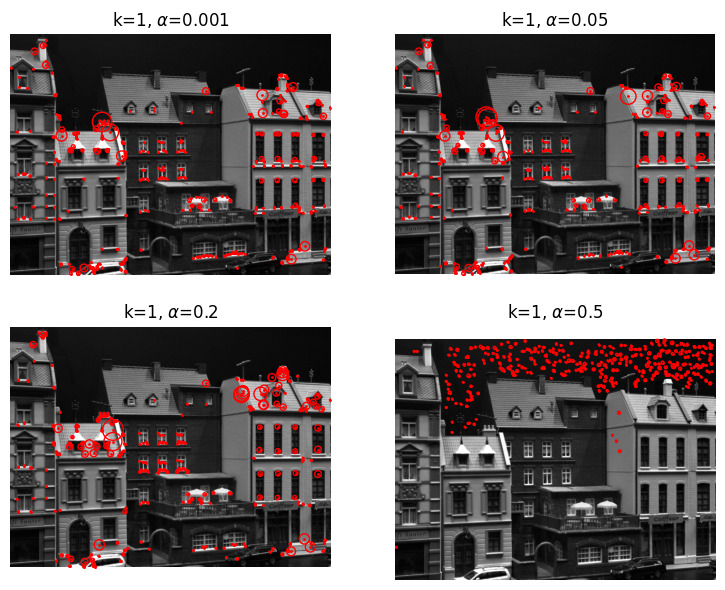

In [3]:
I = img_as_float(imread("modelhouses.png"))

alpha_vals = np.array([0.001, 0.05, 0.2, 0.5])

plt.figure(figsize=(8,6))

for j, alpha in enumerate(alpha_vals):
    x_corner, y_corner, sig_corner = multiscale_Harris_corner(I, k=1, alpha=alpha)

    plt.subplot(2,2,j+1)
    plt.imshow(I, vmin=0, vmax=1, cmap="gray")

    for i in range(len(sig_corner)):
        plt.scatter(x_corner[i], y_corner[i], s=1, c="red")
        circle = plt.Circle((x_corner[i], y_corner[i]), sig_corner[i], fill=False, color="red")
        plt.gca().add_patch(circle)

    plt.axis("off")
    plt.title(fr"k=1, $\alpha$={alpha}")

plt.tight_layout()

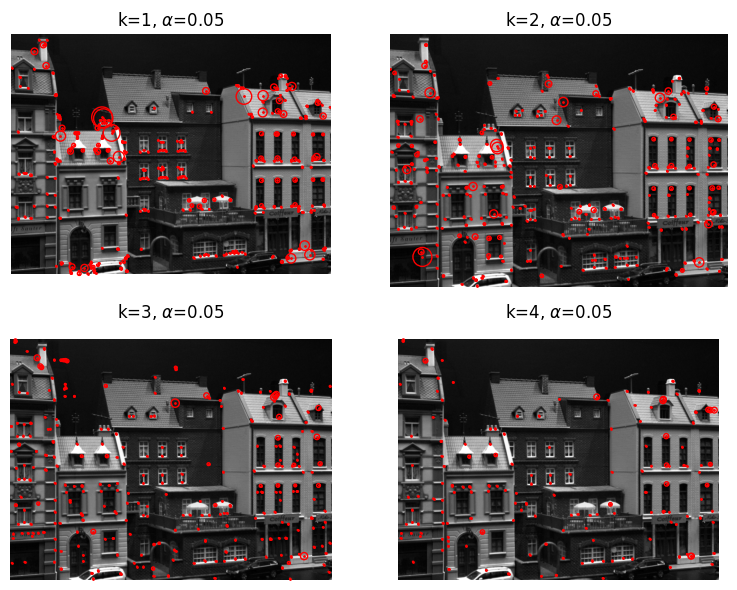

In [4]:
k_vals = np.array([1, 2, 3, 4])

plt.figure(figsize=(8,6))

for j, k in enumerate(k_vals):
    x_corner, y_corner, sig_corner = multiscale_Harris_corner(I, k=k, alpha=0.05)

    plt.subplot(2,2,j+1)
    plt.imshow(I, vmin=0, vmax=1, cmap="gray")

    for i in range(len(sig_corner)):
        plt.scatter(x_corner[i], y_corner[i], s=1, c="red")
        circle = plt.Circle((x_corner[i], y_corner[i]), sig_corner[i], fill=False, color="red")
        plt.gca().add_patch(circle)

    plt.axis("off")
    plt.title(fr"k={k}, $\alpha$=0.05")

plt.tight_layout()

## 5. Fourier Transform - Practice

### Problem 5.1

In [5]:
def scale_fft(image, sigma):
    sigma_fft = len(image) / (2*np.pi*sigma)  # width of gaussian in Fourier space
    gaussian1d = gaussian(len(image), sigma_fft)
    gaussian2d = np.outer(gaussian1d, gaussian1d)  # create kernel
    gaussian2d /= np.sum(gaussian2d)  # normalize

    I_filtered_fft = gaussian2d * fftshift(fft2(image))  # apply filter
    I_filtered = np.real(ifft2(ifftshift(I_filtered_fft)))

    return I_filtered

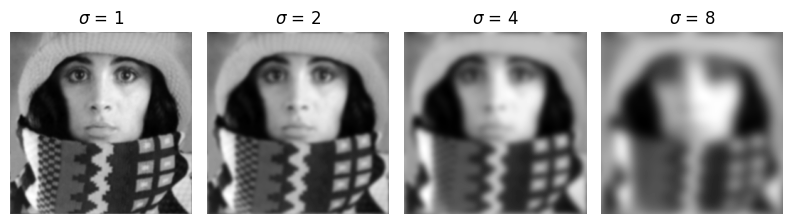

In [6]:
I2 = img_as_float(imread("trui.png"))

sig_values = np.array([1,2,4,8])
filtered_I_array = np.zeros((I2.shape[0], I2.shape[0], len(sig_values)))

for i, sig in enumerate(sig_values):
    filtered_I_array[:,:,i] = scale_fft(I2, sig)

plt.figure(figsize=(10,4))

for i, sig in enumerate(sig_values):
    plt.subplot(1,5,i+1)
    plt.imshow(filtered_I_array[:,:,i], cmap="gray")
    plt.axis("off")
    plt.title(rf"$\sigma$ = {sig}")

plt.tight_layout()

### Problem 5.2

In [7]:
def deriv_filter(image, n, m):
    I_fft = fftshift(fft2(image))  # perform Fourier transform

    # make frequency grid
    u = np.arange(image.shape[1]) / image.shape[1] - 1/2
    v = np.arange(image.shape[0]) / image.shape[0] - 1/2
    U, V = np.meshgrid(u, v)

    # make filter kernel
    deriv_kernel = (1j * 2 * np.pi)**(n+m) * U**n * V**m

    # apply filter
    I_deriv_fft = deriv_kernel * I_fft
    I_deriv = np.real(ifft2(ifftshift(I_deriv_fft)))

    return  I_deriv

Text(0.5, 1.0, '$\\partial^2 I / \\partial y^2$')

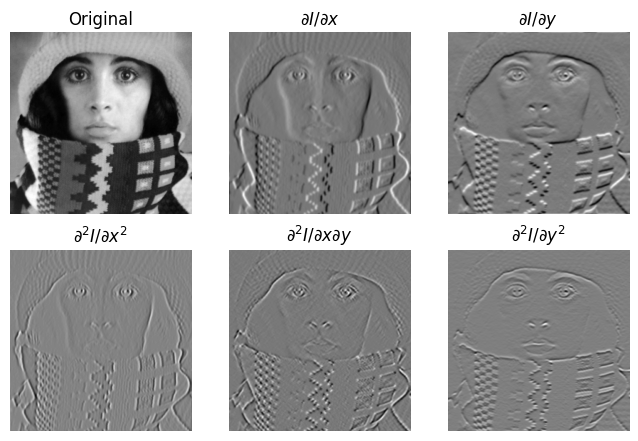

In [8]:
I3 = img_as_float(imread("trui.png"))

plt.figure(figsize=(8,8))

plt.subplot(3,3,1)
plt.imshow(I3, cmap="gray")
plt.axis("off")
plt.title("Original")

I3 = scale_fft(I3, 1)  # smooth with gaussian filter

plt.subplot(3,3,2)
x10 = deriv_filter(I3, 1, 0)
plt.imshow(x10[1:-1, 1:-1], cmap="gray")
plt.axis("off")
plt.title(r"$\partial I / \partial x$")

plt.subplot(3,3,3)
x01 = deriv_filter(I3, 0, 1)
plt.imshow(x01[1:-1, 1:-1], cmap="gray")
plt.axis("off")
plt.title(r"$\partial I / \partial y$")

plt.subplot(3,3,5)
x11 = deriv_filter(I3, 1, 1)
plt.imshow(x11[2:-2, 2:-2], cmap="gray")
plt.axis("off")
plt.title(r"$\partial^2 I / \partial x \partial y$")

plt.subplot(3,3,4)
x20 = deriv_filter(I3, 2, 0)
plt.imshow(x20[2:-2, 2:-2], cmap="gray")
plt.axis("off")
plt.title(r"$\partial^2 I / \partial x^2$")

plt.subplot(3,3,6)
x02 = deriv_filter(I3, 0, 2)
plt.imshow(x02[2:-2, 2:-2], cmap="gray")
plt.axis("off")
plt.title(r"$\partial^2 I / \partial y^2$")